# <center>Data Stationarity and Decomposition (Part 3)</center>

In this notebook, we import the data that has been cleaned and standardized in the previous section. We then proceed to assess its stationarity and decompose it into its trend, seasonal, and residual components. While we plan to retain the outliers for model training, we also explore and visualize them to gain a general overview and for potential future investigations.

## Contents:

* Data Stationarity
* Outlier Exploration

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

color_pal = sns.color_palette()
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

## Load Dataset

In [ ]:
# Method 1 reading the dataset:
df = pd.read_pickle('../input/wavebnetwork/Cleaned_Hourly_Data.sav')
df.head()

,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,Hmax,THmax
time,,,,,,
2020-04-14 12:00:00+00:00,10.837778,328.161111,6.161028,137.113889,225.5,1.100556
2020-04-14 13:00:00+00:00,11.015000,340.350000,6.523222,135.211111,218.0,1.040556
2020-04-14 14:00:00+00:00,11.188333,268.466667,6.906556,136.216667,212.0,1.147778
2020-04-14 15:00:00+00:00,11.463889,246.172222,6.903889,135.855556,221.0,1.951667
2020-04-14 16:00:00+00:00,11.409444,350.311111,7.020000,124.566667,183.0,1.278889


In [ ]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear
df['week'] = df.index.isocalendar().week.astype('int')

df['year_month'] = df[['year', 'month']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df['year_week'] = df[['year', 'week']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df['year_dayofyear'] = df[['year', 'dayofyear']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df.head()

,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,Hmax,THmax,year,quarter,month,dayofyear,week,year_month,year_week,year_dayofyear
time,,,,,,,,,,,,,,
2020-04-14 12:00:00+00:00,10.837778,328.161111,6.161028,137.113889,225.5,1.100556,2020,2,4,105,16,2020-4,2020-16,2020-105
2020-04-14 13:00:00+00:00,11.015000,340.350000,6.523222,135.211111,218.0,1.040556,2020,2,4,105,16,2020-4,2020-16,2020-105
2020-04-14 14:00:00+00:00,11.188333,268.466667,6.906556,136.216667,212.0,1.147778,2020,2,4,105,16,2020-4,2020-16,2020-105
2020-04-14 15:00:00+00:00,11.463889,246.172222,6.903889,135.855556,221.0,1.951667,2020,2,4,105,16,2020-4,2020-16,2020-105
2020-04-14 16:00:00+00:00,11.409444,350.311111,7.020000,124.566667,183.0,1.278889,2020,2,4,105,16,2020-4,2020-16,2020-105


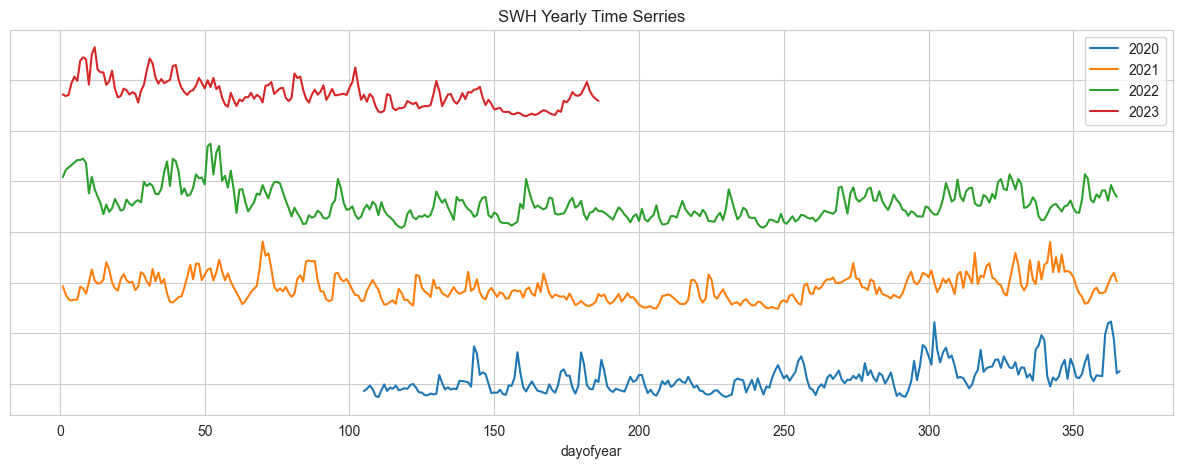

In [ ]:
#sns.set_style('whitegrid')
#plt.style.use('seaborn-v0_8')
#plt.style.use('dark_background')
piv = pd.pivot_table(df, index=['dayofyear'],columns=['year'], values=['SWH'])
piv.columns = piv.columns.levels[1].rename(None)
piv[2020] = piv[2020]+800
piv[2021] = piv[2021]+1700
piv[2022] = piv[2022]+2500
piv[2023] = piv[2023]+3600
ax = piv.plot(figsize=(15,5), title='SWH Yearly Time Serries')
plt.tick_params(labelleft = False)
plt.show()

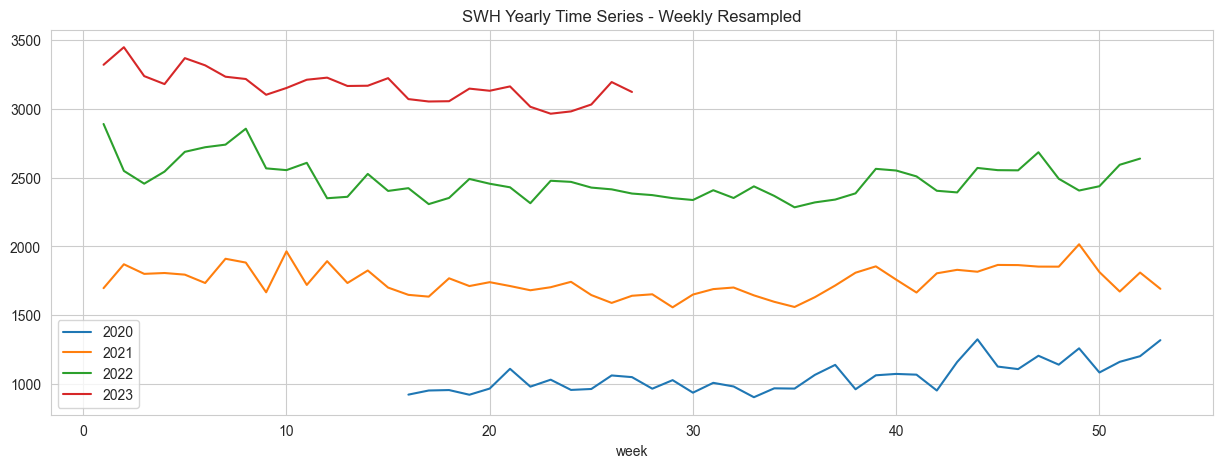

In [ ]:
piv2 = pd.pivot_table(df, index='week',columns=['year'], values=['SWH'])
piv2.columns = piv2.columns.levels[1].rename(None)
piv2[2020] = piv2[2020]+800
piv2[2021] = piv2[2021]+1500
piv2[2022] = piv2[2022]+2200
piv2[2023] = piv2[2023]+2900
piv2.plot(figsize=(15,5), title='SWH Yearly Time Series - Weekly Resampled')
plt.show()

In [ ]:
def smoothing_per_year_plot(df, period, plot, title):
    col = f'year_{period}'
    #df[newcol] = df[['year', period]].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
    if period in(['month','day']):
        df[col] = pd.to_datetime(df[col])

    piv = pd.pivot_table(df, index=[period], columns=['year'], values=['SWH'], aggfunc='median')
    fig, ax = plt.subplots(figsize=(15,3))

    piv.plot(ax=ax)
    ax.legend(title ='Year',fontsize=10)
    ax.set_title(f'({plot}) - SWH {title} Resampled Time Series')

    plt.show()

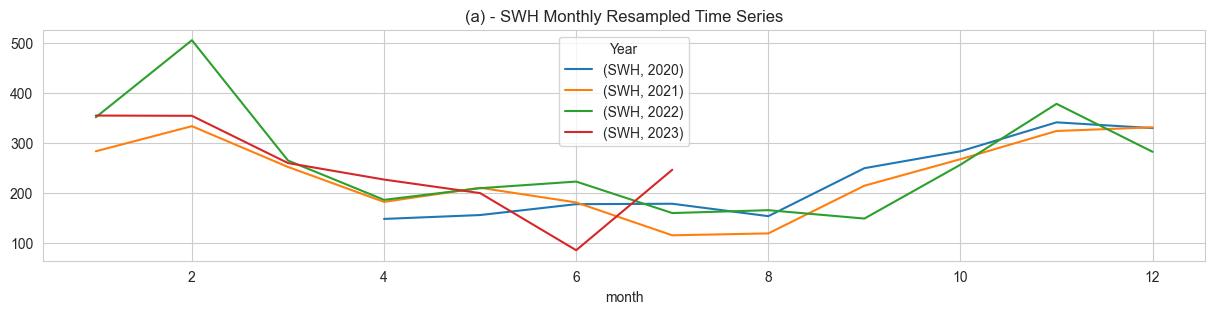

In [ ]:
smoothing_per_year_plot(df, 'month', 'a', 'Monthly')

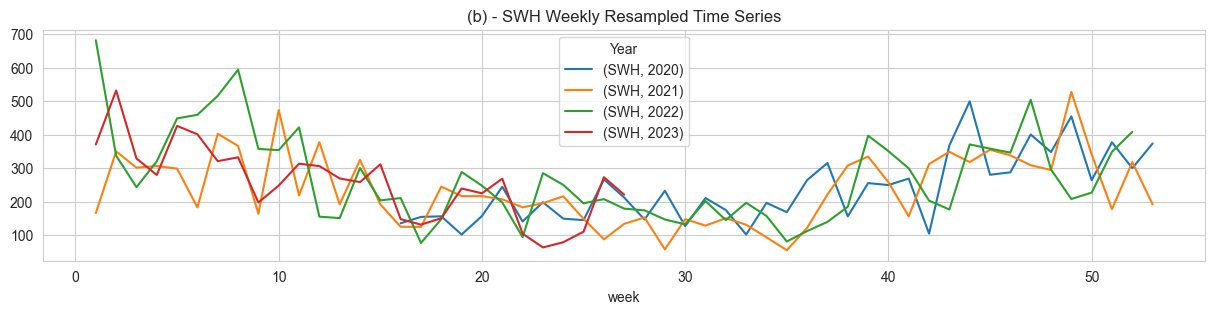

In [ ]:
smoothing_per_year_plot(df, 'week', 'b', 'Weekly')

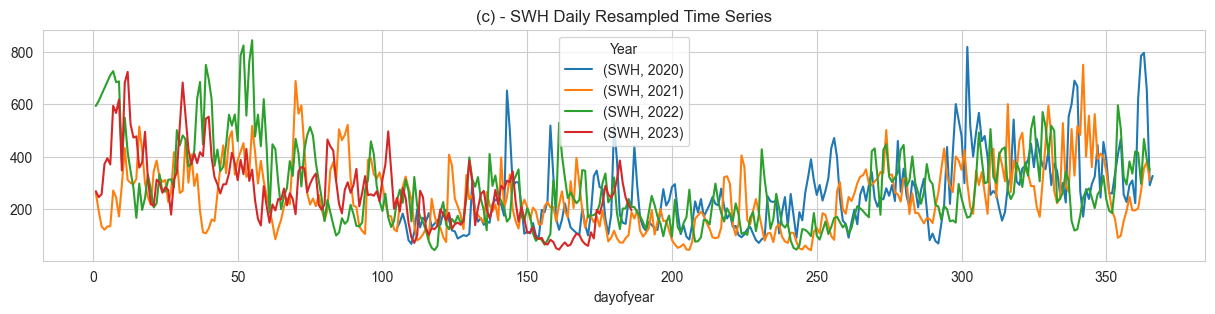

In [ ]:
smoothing_per_year_plot(df, 'dayofyear', 'c', 'Daily')

### Decomposition

In [ ]:
# train an STL model
stl = STL(df['SWH'], period = 365*24)
result = stl.fit()

In [ ]:
# save a model on the disk
# filename = 'STL_model_h.sav'
# pickle.dump(result, open(filename, 'wb'))

# load previously trained STL model from disk
# import pickle
# loaded_model = pickle.load(open("STL_model_1h.sav", 'rb'))
# result = loaded_model

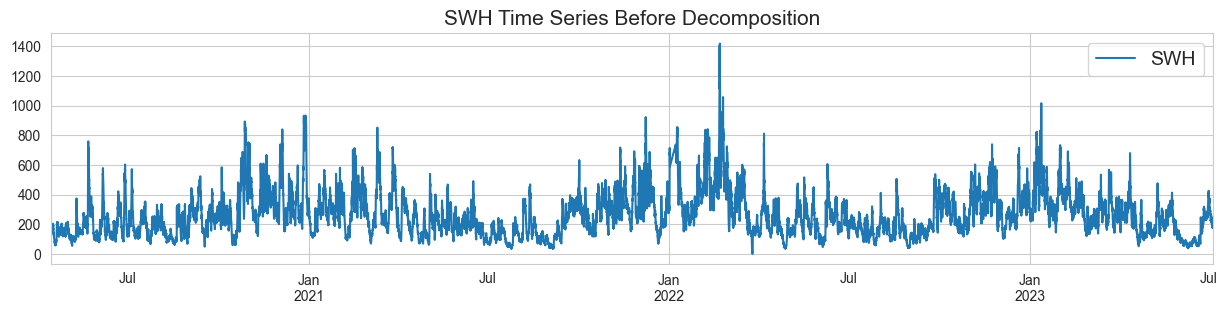

In [ ]:
ax = df['SWH'].plot(figsize=(15,3))
ax.set(xlabel=None)
ax.set_title('SWH Time Series Before Decomposition', fontsize=15)
ax.legend(fontsize=14)
plt.show()

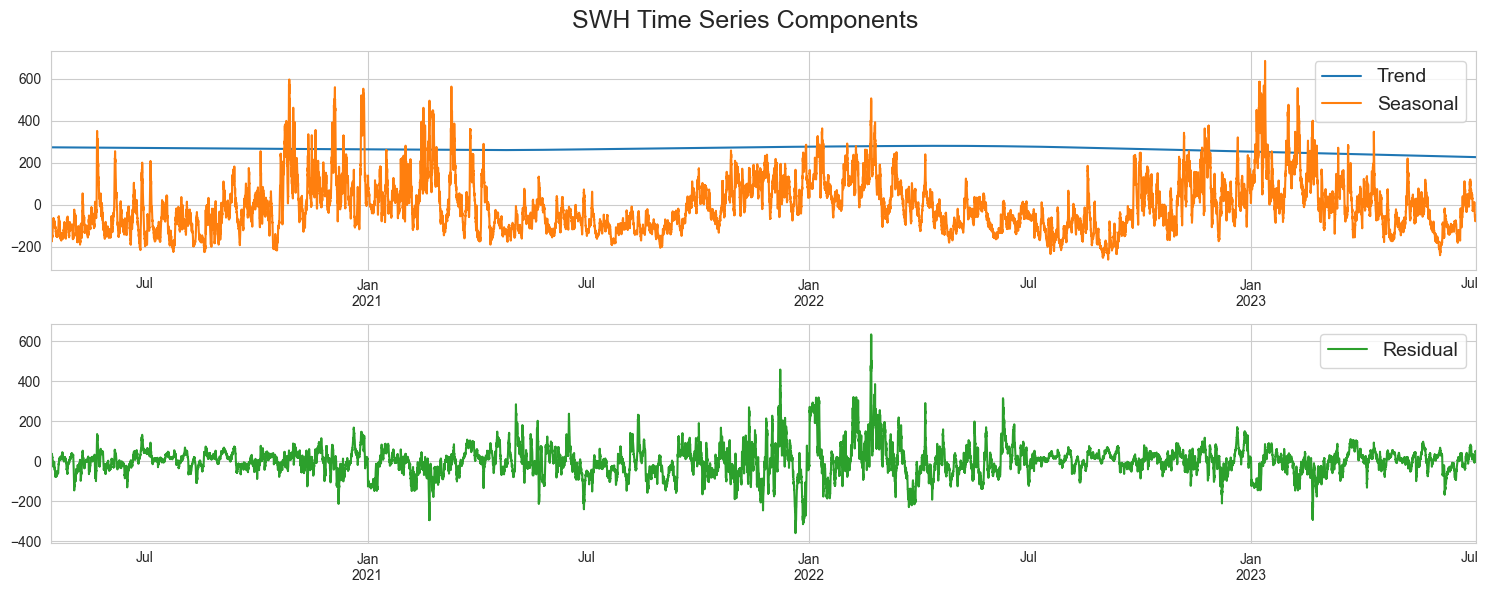

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(15,6))

result.trend.plot(ax=axs[0], label='Trend')
result.seasonal.plot(ax=axs[0], label='Seasonal')
axs[0].legend(fontsize=14)
axs[0].set(xlabel=None)


# plot the residuals
result.resid.plot(ax=axs[1], label='Residual', color=color_pal[2])
axs[1].legend(fontsize=14)
axs[1].set(xlabel=None)


fig.suptitle('SWH Time Series Components', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# Add decomposed elements of SWH to main dataset
df['resid'] = result.resid
df['seasonal'] = result.seasonal
df['trend'] = result.trend

In [ ]:
df.columns

Index(['PeakPeriod', 'PeakDirection', 'UpcrossPeriod', 'SWH', 'Hmax', 'THmax',
       'year', 'quarter', 'month', 'dayofyear', 'week', 'year_month',
       'year_week', 'year_dayofyear', 'resid', 'seasonal', 'trend'],
      dtype='object')

In [ ]:
# remove additional helper columns
df = df.drop(['year', 'quarter', 'month', 'dayofyear', 'week',
              'year_month','year_week', 'year_dayofyear',], axis=1)

In [ ]:
# Save Data
df.to_pickle('../input/wavebnetwork/Stationary_Data')

## Outlier Exploration (Suplimentary for future expolration)
Returning the additional helper time features

In [ ]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear
df['week'] = df.index.isocalendar().week.astype('int')

df['year_month'] = df[['year', 'month']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df['year_week'] = df[['year', 'week']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df['year_dayofyear'] = df[['year', 'dayofyear']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
df['year_quarter'] = df[['year', 'quarter']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')

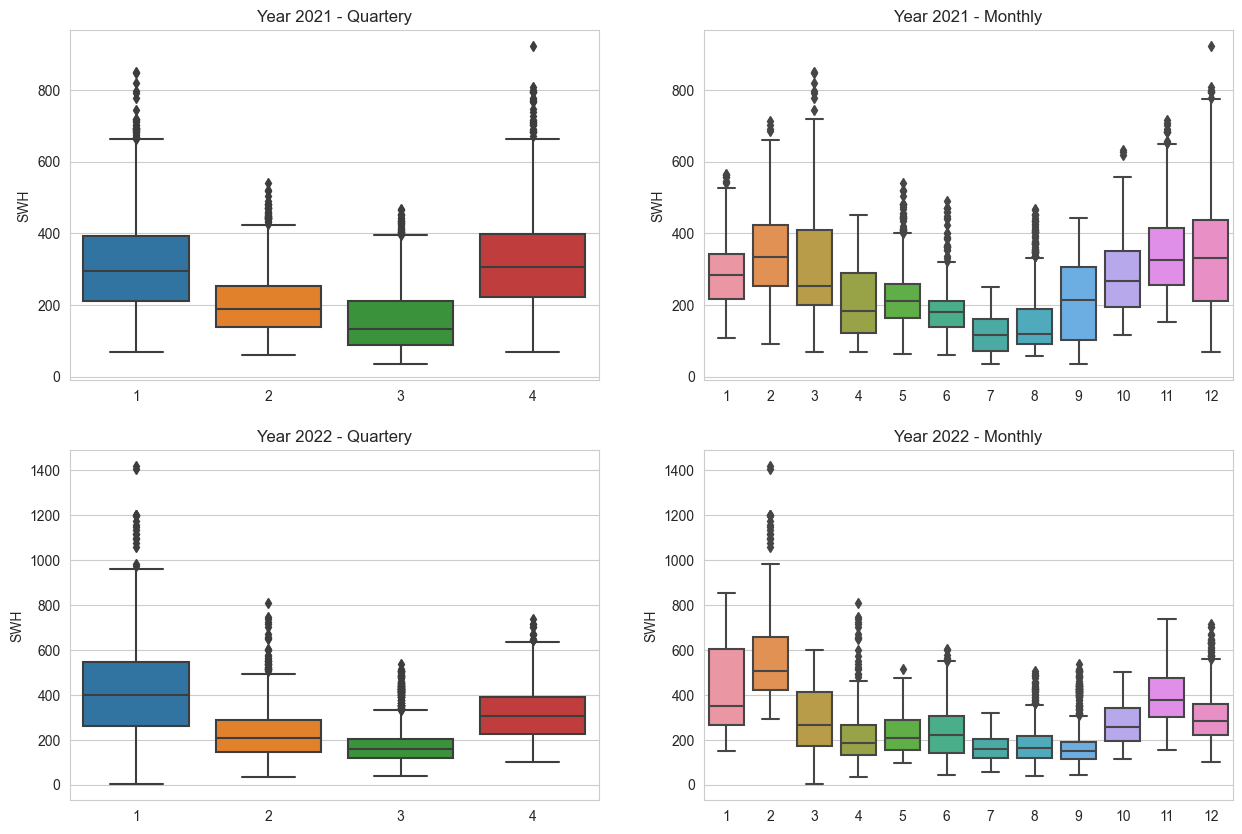

In [ ]:
figure, axs = plt.subplots(2,2,figsize=(15,10))
sns.boxplot(ax= axs[0,0], data=df[df.index.year==2021], y='SWH', x='quarter') 
sns.boxplot(ax= axs[1,0], data=df[df.index.year==2022], y='SWH', x='quarter') 
sns.boxplot(ax= axs[0,1], data=df[df.index.year==2021], y='SWH', x='month') 
sns.boxplot(ax= axs[1,1], data=df[df.index.year==2022], y='SWH', x='month')

axs[0,0].set_title('Year 2021 - Quartery')
axs[1,0].set_title('Year 2022 - Quartery')
axs[0,1].set_title('Year 2021 - Monthly')
axs[1,1].set_title('Year 2022 - Monthly')

axs[0,0].set(xlabel=None)
axs[1,0].set(xlabel=None)
axs[0,1].set(xlabel=None)
axs[1,1].set(xlabel=None)


plt.show()

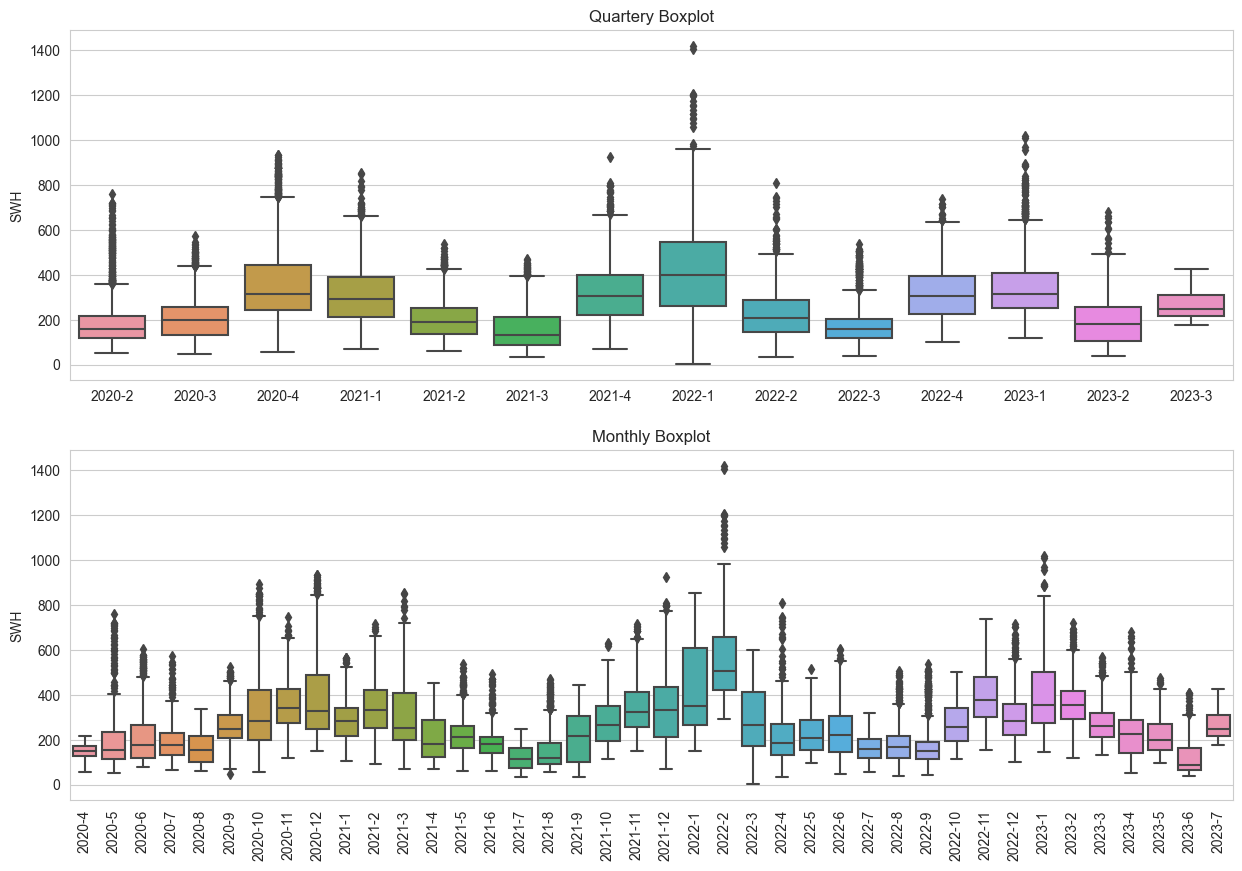

In [ ]:
figure, axs = plt.subplots(2,1,figsize=(15,10))
sns.boxplot(ax= axs[0], data=df, y='SWH', x='year_quarter') 
sns.boxplot(ax= axs[1], data=df, y='SWH', x='year_month')

axs[0].set_title('Quartery Boxplot')
axs[1].set_title('Monthly Boxplot')

axs[0].set(xlabel=None)
axs[1].set(xlabel=None)

plt.xticks(rotation = 90)

plt.show()

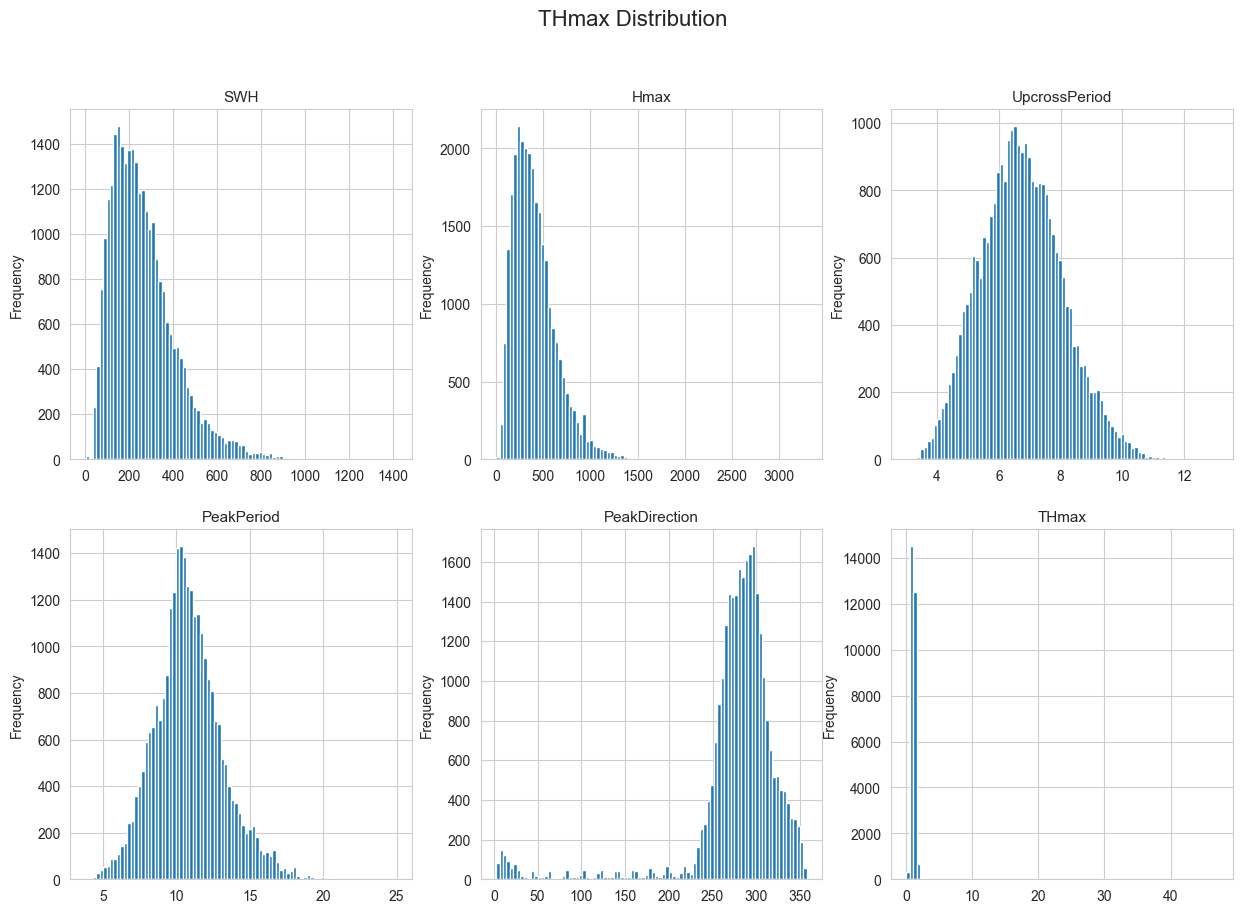

In [ ]:
variables = ['SWH','Hmax','UpcrossPeriod', 'PeakPeriod', 'PeakDirection', 'THmax']
fig, axs = plt.subplots(2,3, figsize=(15,10))

k=0
for i in (0,1):
    for j in (0,1,2):
        variable = variables[k]
        df[variable].plot(ax=axs[i,j],
                          kind='hist',
                          bins=90)
        axs[i,j].set_title(variable,size=11)
        j+=1
        k+=1
    i+=1
        
fig.suptitle(f'{variable} Distribution',fontsize=16)
plt.show()



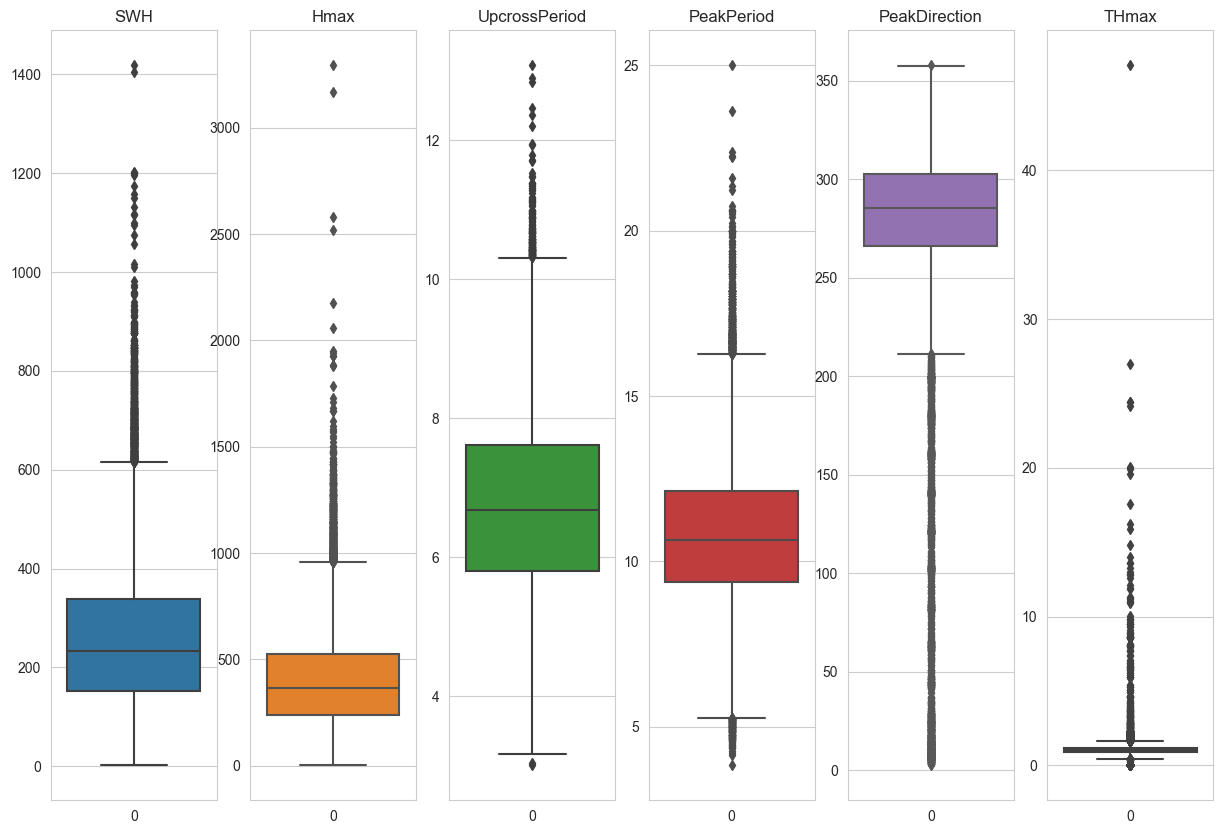

In [ ]:
variables = ['SWH','Hmax','UpcrossPeriod', 'PeakPeriod', 'PeakDirection', 'THmax']
fig, axs = plt.subplots(1,6, figsize=(15,10))

c=0
for variable, ax in zip(variables, axs.ravel()):
    sns.boxplot(ax=ax, data = df[variable], color=color_pal[c])
    ax.set_title(variable)
    c+=1

plt.show()

In [ ]:
def plot_high_outlier(df, variable, threshold):
    count = len(df.loc[df[variable] > threshold][variable])
    ax = df.loc[df[variable] > threshold][variable].plot(style='.',
                                                    figsize=(15,3),
                                                    color='Red',
                                                    label=f'{count} points',
                                                    title= f'{variable} High Value Outliers')
    ax.legend()
    plt.show()
    
def plot_low_outlier(df, variable, threshold):
    count = len(df.loc[df[variable] < threshold][variable])
    ax = df.loc[df[variable] < threshold][variable].plot(style='.',
                                                         figsize=(15,3),
                                                         color='Blue',
                                                         label=f'{count} points',
                                                         title= f'{variable} low Value Outliers')
    ax.legend()
    plt.show()

def plot_middle_outlier(df, variable, Lthreshold, Hthreshold):
    count = len(df.loc[(df[variable] > Lthreshold) & (df[variable] < Hthreshold)][variable])
    ax = df.loc[(df[variable] > Lthreshold) & (df[variable] < Hthreshold)][variable].plot(style='.',
                                                                                      figsize=(15,3),
                                                                                      color='Black',
                                                                                      label=f'{count} points',
                                                                                      title= f'{variable} Middle Value Outliers')
    ax.legend()
    plt.show()

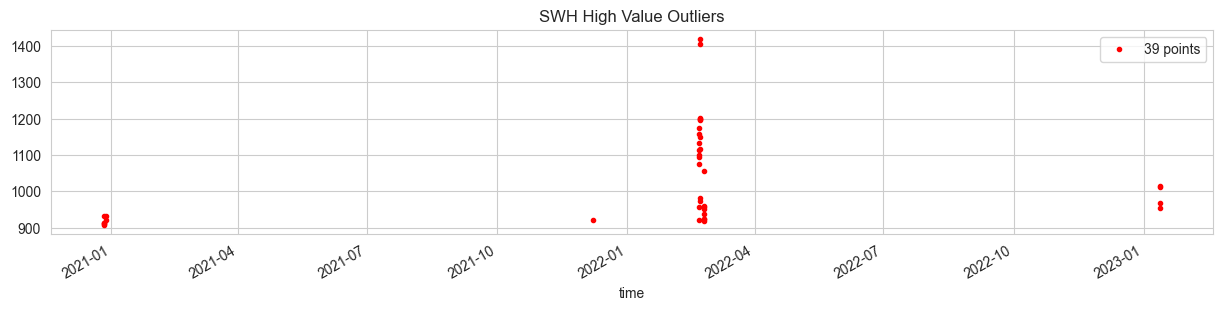

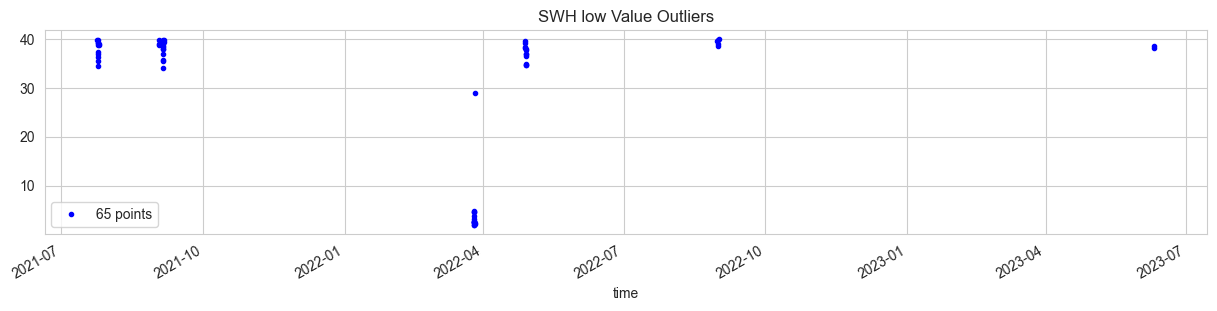

In [ ]:
plot_high_outlier(df,'SWH', 900)
plot_low_outlier(df,'SWH',40)

In [ ]:
# Other variables Outriler detection

# plot_high_outlier(df,'Hmax', 2000)
# plot_low_outlier(df,'Hmax', 60)
# plot_high_outlier(df,'UpcrossPeriod', 12)
# plot_low_outlier(df,'UpcrossPeriod', 3.3)
# plot_high_outlier(df,'PeakPeriod', 20)
# plot_low_outlier(df,'PeakPeriod', 4)
# plot_high_outlier(df,'THmax', 6)
# plot_low_outlier(df,'THmax', 1)
# plot_middle_outlier(df,'PeakDirection', 25, 220)

* For target variable we simply delete the outliers.
* For other features we replace their outlier values with the threshold we found in above plots.

In [ ]:
df = df.drop(df[df['SWH'] >= 900].index)
df = df.drop(df[df['SWH'] <= 40].index)

In [ ]:
# Other variables Outriler removal

# df.loc[df['Hmax'] >= 2000, 'Hmax'] = df.query('Hmax >= 2000')['Hmax'].min()
# df.loc[df['Hmax'] <= 60, 'Hmax'] = df.query('Hmax <= 60')['Hmax'].max()

# df.loc[df['UpcrossPeriod'] >= 12, 'UpcrossPeriod'] = df.query('UpcrossPeriod >= 12')['UpcrossPeriod'].min()
# df.loc[df['UpcrossPeriod'] <= 3.3, 'UpcrossPeriod'] = df.query('UpcrossPeriod <= 3.3')['UpcrossPeriod'].max()

# df.loc[df['PeakPeriod'] >= 20, 'PeakPeriod'] = df.query('PeakPeriod >= 20')['PeakPeriod'].min()
# df.loc[df['PeakPeriod'] <= 4, 'PeakPeriod'] = df.query('PeakPeriod <= 4')['PeakPeriod'].max()

# df.loc[df['THmax'] >= 6, 'THmax'] = df.query('THmax >= 6')['THmax'].min()
# df.loc[df['THmax'] <= 1, 'THmax'] = df.query('THmax <= 1')['THmax'].max()

# df.loc[(df['PeakDirection'] >= 25)&(df['PeakDirection'] < 100), 'PeakDirection'] = df.query('PeakDirection >= 25')['PeakDirection'].min()
# df.loc[(df['PeakDirection'] <= 220)&(df['PeakDirection'] <= 100), 'PeakDirection'] = df.query('PeakDirection <= 220')['PeakDirection'].max()